In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv("/content/customersegmentation.csv", encoding="ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Menghitung persentase missing values
missing_percentage = df.isnull().sum() / len(df) * 100
# Menampilkan hasil
print(missing_percentage)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [6]:
# Menghapus baris yang memiliki nilai kosong di kolom Description dan CustomerID
df = df.dropna()

In [7]:
df.nunique()

,0
InvoiceNo,22190
StockCode,3684
Description,3896
Quantity,436
InvoiceDate,20460
UnitPrice,620
CustomerID,4372
Country,37


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [9]:
df['Country'].value_counts()

,count
Country,
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1480


In [10]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

In [11]:
df = df.drop(columns=['InvoiceNo', 'StockCode', 'Description', 'CustomerID'], errors='ignore')

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Konversi ke datetime
reference_date = df['InvoiceDate'].max()  # Tanggal transaksi terakhir
df['Recency'] = (reference_date - df['InvoiceDate']).dt.days

# hpaus kolom InvoiceDate
df = df.drop(columns=['InvoiceDate'])

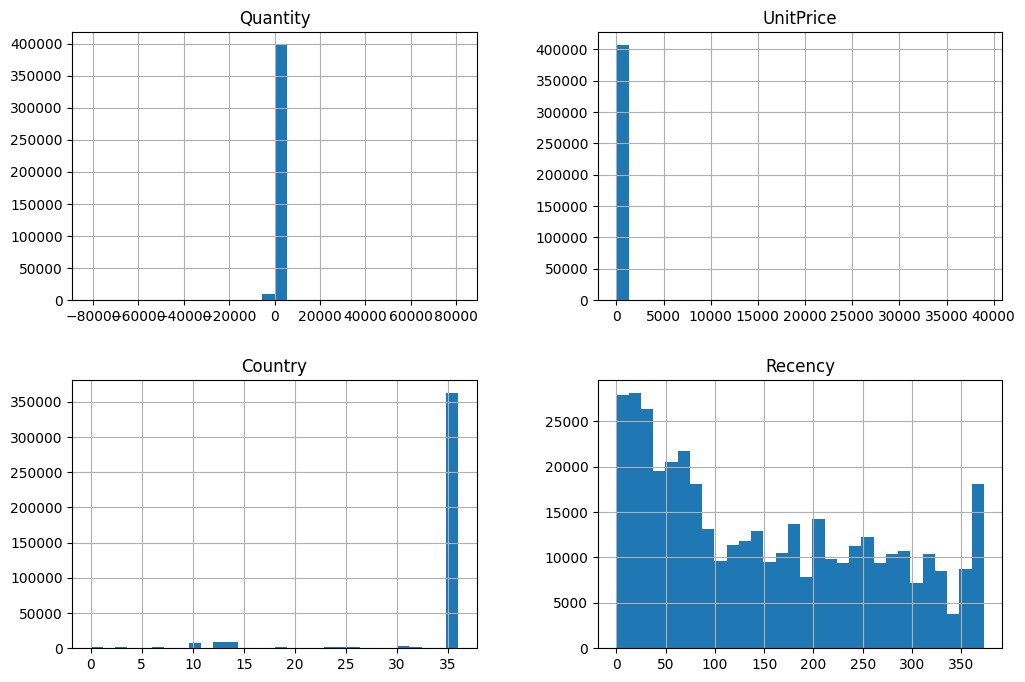

In [13]:
df.hist(figsize=(12, 8), bins=30)
plt.show()

In [14]:
# Hapus outlier dengan metode Interquartile Range (IQR)
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_clean

df = remove_outliers_iqr(df)

In [15]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

K-Means

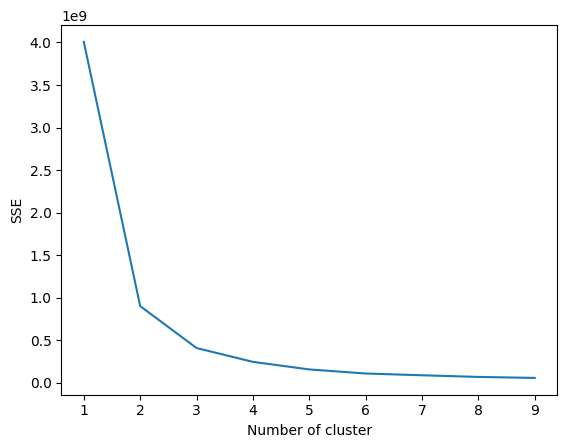

In [16]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

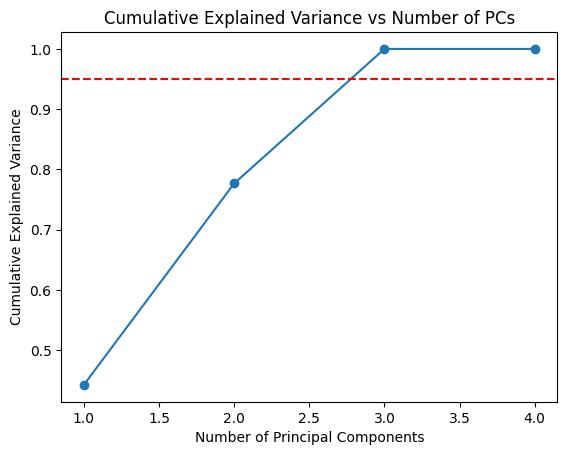

In [17]:
# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Hitung variansi kumulatif
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of PCs')
plt.show()

In [18]:
# Reduksi ke 2D menggunakan PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)  # X_scaled adalah data yang sudah di-scaling

In [19]:
# Lakukan K-Means pada hasil PCA
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

In [20]:
X_pca

array([[ 0.31691788,  1.96138499, -0.12705704],
       [ 0.70058008,  1.98707848,  0.25495783],
       [ 0.19984253,  1.99401453,  0.171438  ],
       ...,
       [ 0.19263461, -1.27259083,  0.5814912 ],
       [-2.25121253, -1.11249322,  1.46867882],
       [ 1.87055026, -1.11975247,  2.66727007]])

In [21]:
# Tambahkan hasil clustering ke dataframe baru
df_pca = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])
df_pca["Cluster"] = clusters

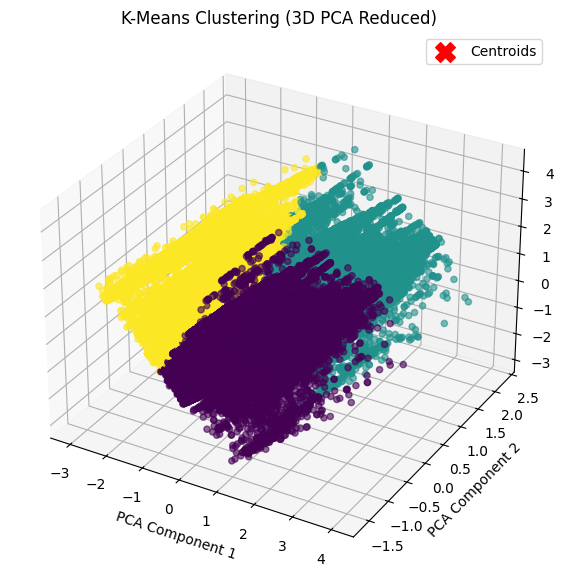

In [22]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot PCA1, PCA2, PCA3
ax.scatter(df_pca["PCA1"], df_pca["PCA2"], df_pca["PCA3"], c=df_pca["Cluster"], cmap="viridis", alpha=0.6)

# Scatter plot centroids
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           s=200, marker="X", c="red", label="Centroids")

# Tambahkan label & judul
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("K-Means Clustering (3D PCA Reduced)")
ax.legend()

plt.show()

In [23]:
# Hitung silhouette score
silhouette_avg = silhouette_score(df_pca[["PCA1", "PCA2", "PCA3"]], df_pca["Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.3151


In [24]:
print("Silhouette Score:", silhouette_score(df_pca, clusters))
print("Davies-Bouldin Score:", davies_bouldin_score(df_pca, clusters))
print("Calinski-Harabasz Score:", calinski_harabasz_score(df_pca, clusters))

Silhouette Score: 0.4117984360579582
Davies-Bouldin Score: 1.010156127336622
Calinski-Harabasz Score: 207978.37636831673


DBSCAN

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import DBSCAN
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics import make_scorer

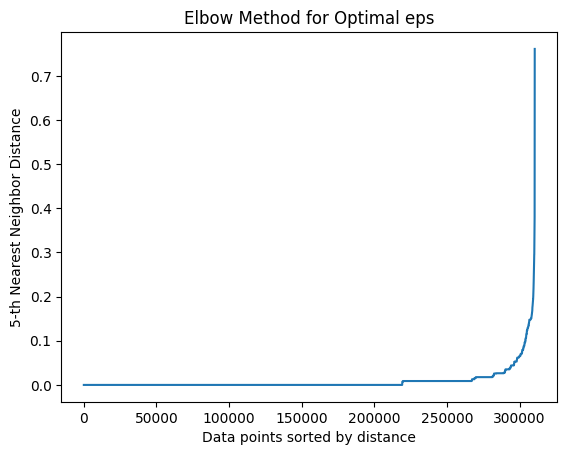

In [26]:
from sklearn.neighbors import NearestNeighbors

k = 5  # min_samples awal
nbrs = NearestNeighbors(n_neighbors=k).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Urutkan jarak ke tetangga ke-k
distances = np.sort(distances[:, k-1])

# Plot elbow method
plt.plot(distances)
plt.xlabel("Data points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("Elbow Method for Optimal eps")
plt.show()

eps=0.15000000000000002, min_samples=3, silhouette_score=-0.1671
eps=0.15000000000000002, min_samples=4, silhouette_score=-0.2232
eps=0.15000000000000002, min_samples=5, silhouette_score=0.1344
eps=0.20000000000000004, min_samples=3, silhouette_score=0.1253
eps=0.20000000000000004, min_samples=4, silhouette_score=0.0082
eps=0.20000000000000004, min_samples=5, silhouette_score=-0.0527
eps=0.20000000000000004, min_samples=6, silhouette_score=-0.1659
eps=0.20000000000000004, min_samples=7, silhouette_score=-0.1777
eps=0.25000000000000006, min_samples=3, silhouette_score=0.1198
eps=0.25000000000000006, min_samples=4, silhouette_score=0.1119
eps=0.25000000000000006, min_samples=5, silhouette_score=0.0705
eps=0.25000000000000006, min_samples=6, silhouette_score=0.0461
eps=0.25000000000000006, min_samples=7, silhouette_score=0.0499
eps=0.25000000000000006, min_samples=8, silhouette_score=-0.0302
eps=0.25000000000000006, min_samples=9, silhouette_score=-0.0481
eps=0.30000000000000004, min_samp

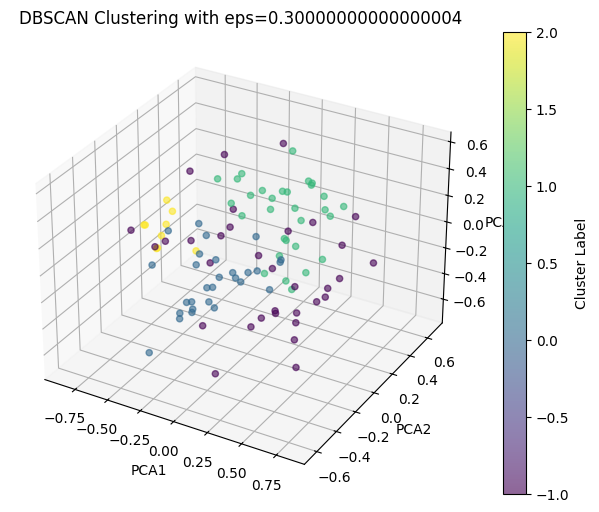

In [27]:
# Contoh data: Asumsikan kita punya dataset 3D hasil PCA
np.random.seed(42)
X = np.random.rand(100, 5)  # Data awal dengan 5 fitur

# Reduksi dimensi ke 3 komponen menggunakan PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Konversi ke DataFrame agar bisa digunakan lebih mudah
X_pca_df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2", "PCA3"])

# Range parameter untuk DBSCAN
eps_values = np.arange(0.1, 0.5, 0.05)
min_samples_values = range(3, 10)

# Inisialisasi nilai terbaik
best_eps = None
best_min_samples = None
best_score = -1  # Mulai dari nilai terendah

# Mencari kombinasi parameter terbaik berdasarkan Silhouette Score
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_pca)

        # Pastikan ada lebih dari 1 cluster sebelum menghitung silhouette score
        if len(set(clusters)) > 1:
            score = silhouette_score(X_pca, clusters)
            print(f"eps={eps}, min_samples={min_samples}, silhouette_score={score:.4f}")

            # Simpan kombinasi terbaik
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

# Print parameter terbaik
print(f"\nBest eps: {best_eps}, Best min_samples: {best_min_samples}, Best Silhouette Score: {best_score:.4f}")

# Jalankan DBSCAN dengan parameter terbaik
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_pca)

# Tambahkan hasil clustering ke DataFrame
X_pca_df["Cluster"] = clusters

# Buat plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot dengan warna sesuai cluster
scatter = ax.scatter(X_pca_df["PCA1"], X_pca_df["PCA2"], X_pca_df["PCA3"],
                     c=X_pca_df["Cluster"], cmap="viridis", alpha=0.6)

# Label dan judul
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title(f"DBSCAN Clustering with eps={best_eps}")

# Tambahkan colorbar
plt.colorbar(scatter, label="Cluster Label")

# Tampilkan plot
plt.show()

In [28]:
print("Silhouette Score:", silhouette_score(X_pca, clusters))
print("Davies-Bouldin Score:", davies_bouldin_score(X_pca, clusters))
print("Calinski-Harabasz Score:", calinski_harabasz_score(X_pca, clusters))

Silhouette Score: 0.19146455480861074
Davies-Bouldin Score: 2.19398985569841
Calinski-Harabasz Score: 19.448152778182386
